In [1]:
# Cody Giles - Student ID: 010506641
# C964 Capstone - Movie Audience Rating Predictor aka The MARP

# For development - auto reloads py files to refresh the cache
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from actor_encoder import ActorEncoder
from genre_encoder import GenreEncoder

# Display more than one table in a single cell
from IPython.display import display
from movie_data_loader import MovieDataLoader
from movie_pipeline import MoviePipeline
from one_hot_encoder import OneHotEncoder
from r_score import RScore

# read data
from sklearn.datasets import load_iris
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


ModuleNotFoundError: No module named 'actor_encoder'

In [ ]:
genre_encoder = GenreEncoder()
actor_encoder = ActorEncoder()
one_hot_encoder = OneHotEncoder()
pipeline = MoviePipeline()
load_movie_data = MovieDataLoader('imdb_movies.csv')

# Show a sample of the loaded movie data
df = load_movie_data.load_preprocess()
display(df.head())

display(r_score)

Loaded 10075 movies that were released prior to 2024. Here's a sample below:


,date,score,genre,cast,lang,budget,country
0,1903-05-15,6.3,"[Drama, History]","[Madame Moreau, Monsieur Moreau]",French,106400000.0,FR
1,1907-06-20,8.0,"[Adventure, Science Fiction]","[Georges Meliès, Bleuette Bernon, François Lal...",French,5985.0,AU
2,1915-02-08,6.1,"[Drama, History, War]","[Lillian Gish, Mae Marsh, Henry B. Walthall, M...",English,110000.0,US
3,1920-02-27,8.0,"[Drama, Horror, Thriller, Crime]","[Werner Krauß, Conrad Veidt, Friedrich Feher, ...",German,18000.0,DE
4,1923-04-01,7.9,"[Comedy, Romance, Thriller]","[Harold Lloyd, Mildred Davis, Bill Strother, N...",English,121000.0,US


hello


NameError: name 'r_score' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('score', axis=1),
    df['score'],
    shuffle=False,
    test_size=.25)

pipeline = MoviePipeline()
pipeline.fit(X_train, y_train)
# pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Test R² Score: {test_score:.4f}")

Test R² Score: 0.3217


In [ ]:
# Deadpool vs Wolverine (actual is a 7.5 rating)
pipeline = MoviePipeline()
pipeline.fit(X_train, y_train)

deadpool = pipeline.inference(
    date='2024-07-26',
    genre=['Action', 'Comedy', 'Superhero', 'Buddy Comedy', 'Adventure'],
    cast=['Ryan Reynolds', 'Hugh Jackman', 'Emma Corrin', 'Matthew Macfadyen',
          'Dafne Keen', 'Jon Favreau', 'Morena Baccarin', 'Rob Delaney', 'Leslie Uggams'],
    lang='English',
    budget=533000000,
    country='US'
)

print("The MARP predicts that it will have an audience rating of ", round(deadpool, 1))

The MARP predicts that it will have an audience rating of  6.6


In [ ]:
# GUI
def validate_date(date_str):
    try:
        datetime.datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        return False


def validate_budget(budget_str):
    try:
        budget = float(budget_str.replace(',', '').replace('_', ''))
        return budget
    except ValueError:
        print("Invalid budget format. Please enter a numeric value.")
        return None


def validate_input():
    while True:
        date_input = input(
            "What is the release date of the movie? YYYY-MM-DD format: ")
        if not validate_date(date_input):
            continue

        user_genres = input(
            "Genre of the movie? Can be multiple, separate with a comma e.g. Comedy, Action: ")
        genres = [s.strip() for s in user_genres.split(",")]

        cast_input = input(
            "Who's starring in the movie? Can be multiple, separate with a comma: ")
        cast = [s.strip() for s in cast_input.split(",")]

        lang_input = input("What language is the movie in? ")

        budget_input = input("What is the budget of the movie? ")
        budget = validate_budget(budget_input)
        if budget is None:
            continue

        country_input = input(
            "Where is the movie from? Use ISO 3166 country codes, e.g. US, AU, KR (Korea), etc.: ")

        return {
            'date': date_input,
            'genre': genres,
            'cast': cast,
            'lang': lang_input,
            'budget': budget,
            'country': country_input
        }


while True:
    inputs = validate_input()
    output = pipeline.inference(
        date=inputs['date'],
        genre=inputs['genre'],
        cast=inputs['cast'],
        lang=inputs['lang'],
        budget=inputs['budget'],
        country=inputs['country']
    )
    print(
        f"Your movie will have an estimated audience/user score of: {round(output, 1)}")
    break

Your movie will have an estimated audience/user score of: 6.4


In [ ]:
v = pipeline.feature_importance
v

,feature,importance
59,lang_Korean,0.124153
32,Animation,0.093776
79,country_AU,0.077974
20,Drama,0.041583
108,country_KR,0.039496
...,...,...
114,country_PH,0.000000
112,country_NO,0.000000
117,country_PY,0.000000
126,country_XC,0.000000


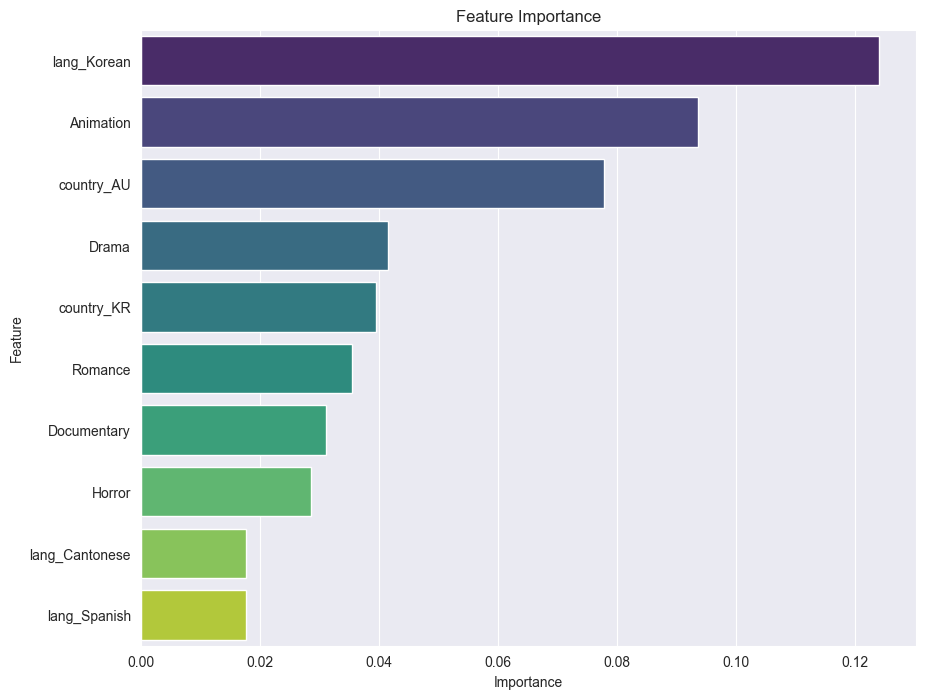

In [ ]:
# Extract feature importances
feature_importance_df = pd.DataFrame({
    'feature': pipeline.model.get_booster().feature_names,
    'importance': pipeline.model.feature_importances_
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(
    by='importance', ascending=False).head(10)

# Plotting with Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance',
    y='feature',
    hue='feature',
    data=feature_importance_df,
    palette='viridis',
    legend=False
)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

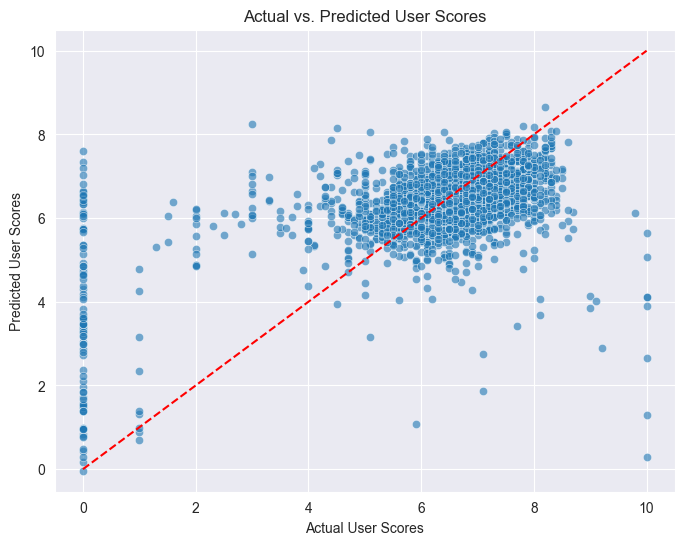

In [ ]:
# Generate predictions
y_pred = pipeline.predict(X_test)

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)

# Add a reference line y = x (perfect prediction)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--')

plt.title('Actual vs. Predicted User Scores')
plt.xlabel('Actual User Scores')
plt.ylabel('Predicted User Scores')
plt.show()

<Axes: xlabel='score', ylabel='Count'>

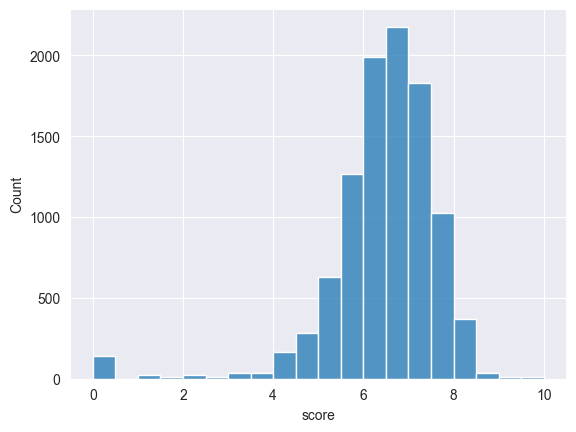

In [ ]:
sns.histplot(df['score'], bins=20)

In [ ]:
# Generate predictions
y_pred = pipeline.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

print(f'R² score: {r2:.4f}')

R² score: 0.3216
